# Xiang Qi Piece Recognition Model Building

## Author -- Jesse Thibault

## Table of Contents

* [Introduction](#introduction)
* [Data Augmentation](#data-augment)
    * [Image Augmentation](#image-augment)
* [Model Building](#model-building)
    * [Build Keras Dataset](#keras-dataset)
    * [Model Training](#model-training)
    * [Model Export](#model-export)
    * [Test Model](#image-test)
* [Conclusion](#conclusion)

## Introduction <a class="anchor" id="introduction"></a>

In this project, I aim to generate a virtual Xiang Qi board from a video feed from an edge device. The software running on the edge should be able to perceive a board and its current state, recognize the pieces and their positions on the board, and then replicate the state of the board in virtual space, shown on screen for viewers. I expect this to be challenging and potentially we won't be able to complete the entire goals. There are a number of challenges ahead of us:

* Gather images of Xiang Qi pieces
    * I could not find good universal repositories of photos of pieces, I had to generate the data by hand
    * Clean the images to specific sizes
    * Augment the data for different reference angles (rotate pieces, skew pieces)
* Build the model on a more powerful machine
    * I train the model on my workstation, and transfer the model to a Cloud service
    * I planned to use PySpark for model training, but could not get it to work in a Windows environment, and switched to Keras

The original plan was to have two edge services. One is the producer, taking frames from a video feed and saving them to disk. The other was the consumer, with shared access to the same disk and would evaluate the images taken and predict their class. Using this information the edge device would know which piece is which, and position them accordingly. In Xiang Qi, usually the pieces are the same size as the spaces they occupy, so positioning is a relatively easier challenge. However, the positioning phase did not happen. The project hit continual brick walls, although finally had a lot of success with individual piece classification via video feed. All of the services will be deployed as Docker images using Kubernetes.

In this notebook, we will cover the data augmentation, model generation, and model testing.

In [1]:
from PIL import Image
from glob import glob

## Data Augmentation <a class="anchor" id="data-augment"></a>

### Transform the pictures of the pieces in all 360 degree angles for training <a class="anchor" id="image-augment"></a>

In [2]:
data = ".\\data\\images"

glob(f'{data}\\*\\')

['.\\data\\128\\', '.\\data\\2048\\', '.\\data\\512\\']

In [3]:
data = ".\\data\\images"

sizes_dirs = glob(f'{data}\\*\\')

for sizes_dir in sizes_dirs:

    piece_dirs = glob(f'{sizes_dir}\\*\\')

    for piece_dir in piece_dirs:

        print(f'Transforming image dir {piece_dir}')

        og_image = Image.open(f'{piece_dir}0.jpg')

        for i in range(1,360):
            rotated_image = og_image.rotate(i)
            rotated_image.save(f'{piece_dir}{i}.jpg')

Transforming image dir .\data\128\green_adviser\
Transforming image dir .\data\128\green_cannon\
Transforming image dir .\data\128\green_chariot\
Transforming image dir .\data\128\green_elephant\
Transforming image dir .\data\128\green_general\
Transforming image dir .\data\128\green_horse\
Transforming image dir .\data\128\green_soldier\
Transforming image dir .\data\128\red_adviser\
Transforming image dir .\data\128\red_cannon\
Transforming image dir .\data\128\red_chariot\
Transforming image dir .\data\128\red_elephant\
Transforming image dir .\data\128\red_general\
Transforming image dir .\data\128\red_horse\
Transforming image dir .\data\128\red_soldier\
Transforming image dir .\data\2048\green_adviser\
Transforming image dir .\data\2048\green_cannon\
Transforming image dir .\data\2048\green_chariot\
Transforming image dir .\data\2048\green_elephant\
Transforming image dir .\data\2048\green_general\
Transforming image dir .\data\2048\green_horse\
Transforming image dir .\data\2048

## Model Building <a class="anchor" id="model-building"></a>

### Build up Keras Dataset <a class="anchor" id="keras-dataset"></a>

In [1]:
import keras
import tensorflow as tf
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
DATA_DIR = './data/images/128'

In [5]:
train = image.image_dataset_from_directory(DATA_DIR, labels='inferred', label_mode='int', subset='training', seed=42, validation_split=0.2)
validation = image.image_dataset_from_directory(DATA_DIR, labels='inferred', label_mode='int', subset='validation', seed=42, validation_split=0.2)

Found 5040 files belonging to 14 classes.
Using 4032 files for training.
Found 5040 files belonging to 14 classes.
Using 1008 files for validation.


In [6]:
class_names = train.class_names
print(class_names)

['green_adviser', 'green_cannon', 'green_chariot', 'green_elephant', 'green_general', 'green_horse', 'green_soldier', 'red_adviser', 'red_cannon', 'red_chariot', 'red_elephant', 'red_general', 'red_horse', 'red_soldier']


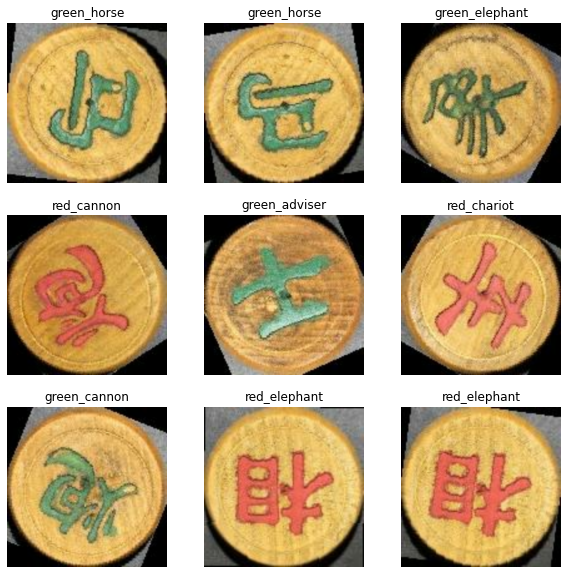

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


### Model Training <a class="anchor" id="model-training"></a>

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = validation.cache().prefetch(buffer_size=AUTOTUNE)

image_size = (128, 128)

In [10]:
num_classes = 14

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [11]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [12]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
126/126 [==============================] - 73s 578ms/step - loss: 1.4359 - accuracy: 0.4893 - val_loss: 0.4599 - val_accuracy: 0.8353
Epoch 2/3
126/126 [==============================] - 71s 567ms/step - loss: 0.0573 - accuracy: 0.9849 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 3/3
126/126 [==============================] - 72s 568ms/step - loss: 9.0319e-04 - accuracy: 1.0000 - val_loss: 7.1970e-04 - val_accuracy: 1.0000


### Save model for export <a class="anchor" id="model-export"></a>

In [78]:
model.save('./piece-identifier/models')

INFO:tensorflow:Assets written to: ./models\assets


### Test some images <a class="anchor" id="image-test"></a>

In [80]:
model_loaded = keras.models.load_model('./models')

In [81]:
imgs = image.image_dataset_from_directory('./data/test-predictions')
class_names_test = imgs.class_names

Found 3 files belonging to 3 classes.


In [82]:
predictions = np.array([])
labels =  np.array([], dtype=int)

for x, y in imgs:
  predictions = model_loaded.predict(x)
  labels = np.append(labels, y)

In [83]:
predictions

array([[ 12.075173  ,  13.740192  ,   7.8074775 ,   8.899924  ,
          7.8545737 ,  20.345604  ,   3.8961058 ,   2.6856425 ,
         -4.8192606 ,  -0.04079555,  -3.5590665 , -14.462414  ,
         -4.3976803 ,  -3.8101315 ],
       [ 28.058363  ,  12.354089  ,  11.935104  ,   1.8296739 ,
         12.2258835 ,  16.079397  ,  18.725271  ,   6.489205  ,
         -1.5787423 ,  -8.841201  ,  -5.0101056 ,  -5.872531  ,
        -15.480945  ,   3.5781636 ],
       [ -0.5193223 , -10.943621  ,   6.352803  , -18.87309   ,
        -13.080922  , -15.937597  ,   8.395351  ,  16.477945  ,
         18.446922  ,  -2.679256  ,  -2.1431425 ,  25.213663  ,
        -14.6897    ,  14.634435  ]], dtype=float32)

In [84]:
max_value0 = max(predictions[0])
max_index0 = np.where(predictions[0] == max_value0)
print(f'{class_names_test[labels[0]]} predicted as {class_names[max_index0[0][0]]}')

max_value1 = max(predictions[1])
max_index1 = np.where(predictions[1] == max_value1)
print(f'{class_names_test[labels[1]]} predicted as {class_names[max_index1[0][0]]}')

max_value2 = max(predictions[2])
max_index2 = np.where(predictions[2] == max_value2)
print(f'{class_names_test[labels[2]]} predicted as {class_names[max_index2[0][0]]}')

green_horse predicted as green_horse
green_adviser predicted as green_adviser
red_general predicted as red_general


## Conclusion <a class="anchor" id="conclusion"></a>

The model does an incredble job of piece prediction in the case of still pictures, as we see above. The model is 100% accurate with incredibly small loss after three epochs. 

It took some time tuning the model to work. The original design used PySpark but after repeated attempts to train the model, PySpark with Tensorflow was proving fruitless. The second attempt was to use Keras with Tensorflow which had significantly better results immediately. With the PySpark design, I could not get the model to train on the data at all, but with Keras it was fairly seamless, once the kinks in Tensorflow for Windows were ironed out.

Ultimately the SparkDL dependency needed to be hacked up to get it to run on a Windows system. Multiple .py files in the module needed to be modified in how they referenced Tensorflow, as they used deprecated APIs, and a number of other references to Keras needed to be adjusted as well. Once all the issues were resolved, the model training and saving worked fantastically. 

The original plan to have the edge device be the producer and consumer fell flat. For one thing, the edge device really struggled to compile Tensorflow Docker images and with the Linux aarch64 architecture it was almost impossible to get a working image that could run Keras and all of its dependencies, those being Tensorflow, numpy, grpcio, and a few other large modules. A lot of time was sunk into this model, but in the end we pivoted to a model similar to what we did in Homework 3.

The final design was a producer on the edge which produces a continuous video feed, and sends frames to a MQTT message forwarder in a half-second step. The forwarder pushes the message out to a much more powerful, Linux amd64 Cloud device which can compile and run Tensorflow images much more seamlessly. This service would evaluate images in batches of ten and chooses the most common prediction from among them, and prints this result.

Next step for this service would be to send the result back to the edge device along with the coordinates in the image where the piece was for the edge device to be able to build out the board state. This was the logical next step, but we did not get there. Additionally, the model currently evaluates the entire picture, there was not enough time to train a model to extract pieces from a group image.